In [58]:
import pandas as pd 
import numpy as np
from nltk.corpus import stopwords
import re
import gensim
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from gensim.utils import  simple_preprocess
import spacy
from nltk import bigrams
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from itertools import cycle
from sklearn.metrics import auc 
from sklearn.metrics import roc_curve

In [2]:
df = pd.read_csv('../data/processed/author-parse-articles.csv')
df.head(1)

,Unnamed: 0,art_Unnamed: 0,art_uid,art_article_author,art_article_date,art_article_text,art_article_url,ref_Unnamed: 0,ref_Unnamed: 0.1,ref_uid,ref_title,ref_time,ref_source,ref_time-capture,ref_sc,ref_domain,ref_full-text,ref_sc2,ref_geo,ref_time_parsed
0,0,5,02b5cecd-fac3-4b89-80a2-5bc7d3356d51,['Jake Epstein'],2022-04-04 00:00:00,Lithuania's top diplomat said buying Russian o...,https://www.businessinsider.com/lithuania-dipl...,16,16,02b5cecd-fac3-4b89-80a2-5bc7d3356d51,Lithuanian ambassador to Ukraine to return to ...,4 hours ago,https://twitter.com/idreesali114/status/151098...,2022-04-04 13:47:10.051481,False,"data:image/svg+xml;base64,PHN2ZyB2ZXJzaW9uPSIx...",SourceOn live map\nTell friends\n4 hours ago -...,False,54°41′N 25°16′E,2022-04-04 09:50:58


In [3]:
# Getting Domains From News Websites 
m = df['art_article_url'].str.extract('(?<=http://)(.*?)(?=/)|(?<=https://)(.*?)(?=/)')
m = m[0].fillna(m[1]).fillna(df['art_article_url'])
df['art_extracted_domain'] = m

In [4]:

df.groupby(['art_extracted_domain']).agg("count")["art_uid"].mean()

7.036585365853658

In [5]:
df_domain = df.groupby(['art_extracted_domain']).agg("count")["art_uid"] 
domains = list(df_domain[df_domain>20].index)

In [6]:
df_filter = df[df["art_extracted_domain"].isin(domains)]

In [7]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


In [8]:
news = df_filter[["art_article_text"]]

In [9]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('[,\.!?]', '', sent)  # remove emails
        sent = sent.lower()  
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data = news['art_article_text'].values.tolist()
data = [i for i in data if type(i) != float ]
data_words = list(sent_to_words(data))

In [11]:
# remove stopwords
sentences=[]
for line in data_words:
    try:
        segs = [i for i in line if i not in stop_words]
        sentences.append(segs)
    except:
        print (line)
        continue

# topic discover

In [12]:
# Create Dictionary
id2word = Dictionary(sentences)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in sentences]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [13]:
for topic in lda_model.print_topics(num_topics=10, num_words=8):
    print (topic[1])

0.043*"said" + 0.034*"ukraine" + 0.025*"russian" + 0.024*"russia" + 0.013*"gmt" + 0.012*"war" + 0.011*"ukrainian" + 0.010*"says"
0.046*"russian" + 0.028*"forces" + 0.026*"ukrainian" + 0.026*"city" + 0.018*"kyiv" + 0.016*"military" + 0.014*"troops" + 0.013*"mariupol"
0.025*"ukraine" + 0.022*"us" + 0.015*"putin" + 0.015*"nato" + 0.014*"biden" + 0.012*"war" + 0.011*"russia" + 0.009*"military"
0.038*"sanctions" + 0.021*"russia" + 0.021*"european" + 0.021*"russian" + 0.020*"eu" + 0.018*"said" + 0.014*"gas" + 0.014*"president"
0.018*"region" + 0.010*"armed" + 0.009*"plant" + 0.009*"russian" + 0.008*"according" + 0.008*"today" + 0.008*"head" + 0.008*"one"
0.041*"bucha" + 0.027*"ukraine" + 0.022*"kyiv" + 0.020*"ukrainian" + 0.017*"images" + 0.016*"people" + 0.015*"bodies" + 0.013*"town"
0.048*"russia" + 0.035*"ukraine" + 0.016*"security" + 0.016*"pm" + 0.015*"un" + 0.014*"council" + 0.013*"february" + 0.012*"united"
0.035*"mr" + 0.023*"officials" + 0.022*"new" + 0.021*"russia" + 0.016*"york" +

In [15]:
# Structure the theme, cluster every article topic words and theme and give the possibility. 

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,10), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=sentences)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.424996,"sanctions, russia, european, russian, eu, said...","[lithuanias, top, diplomat, said, buying, russ..."
1,1,3.0,0.649334,"sanctions, russia, european, russian, eu, said...","[live, blog, closed, follow, latest, updates, ..."
2,2,4.0,0.218611,"region, armed, plant, russian, according, toda...","[afu, repels, enemy, attacks, fronts, major, d..."
3,3,9.0,0.393797,"food, region, people, sullivan, pentagon, wedn...","[families, waiting, board, trains, eastern, uk..."
4,4,4.0,0.391495,"region, armed, plant, russian, according, toda...","[timeline, day, ukraines, defense, russian, ag..."
5,5,0.0,0.375793,"said, ukraine, russian, russia, gmt, war, ukra...","[united, states, britain, announced, plans, mo..."
6,6,9.0,0.393797,"food, region, people, sullivan, pentagon, wedn...","[families, waiting, board, trains, eastern, uk..."
7,7,0.0,0.546160,"said, ukraine, russian, russia, gmt, war, ukra...","[soldiers, walk, amid, destroyed, russian, tan..."
8,8,1.0,0.380448,"russian, forces, ukrainian, city, kyiv, milita...","[serhiy, haidai, head, luhansk, regional, mili..."
9,9,8.0,0.998396,"april, said, russian, ukrainian, ukraine, russ...","[russias, defense, ministry, warned, april, in..."


In [16]:
"""get samples of sentences that most represent a given topic."""
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.906988,"said, ukraine, russian, russia, gmt, war, ukrainian, says, mar, moscow","[lviv, next, round, face, face, talks, ukraine, russia, place, turkey, march, ukrainian, negotia..."
1,1.0,0.750999,"russian, forces, ukrainian, city, kyiv, military, troops, mariupol, said, capital","[opposite, turned, true, russian, forces, retreated, around, kyiv, ukrainian, forces, gained, gr..."
2,2.0,0.809869,"ukraine, us, putin, nato, biden, war, russia, military, president, wednesday","[us, president, joe, biden, chinese, president, xi, jinping, virtual, meeting, friday, photo, wh..."
3,3.0,0.899253,"sanctions, russia, european, russian, eu, said, gas, president, putin, oil","[coronavirus, bulletin, stay, informed, daily, latest, news, advice, covid, editors, us, news, w..."
4,4.0,0.620007,"region, armed, plant, russian, according, today, head, one, occupiers, information","[term, search, search, google]"
5,5.0,0.825082,"bucha, ukraine, kyiv, ukrainian, images, people, bodies, town, russian, march","[photos, russia, keep, attacks, parts, ukraine, millions, displaced, editors, note, graphic, con..."
6,6.0,0.698379,"russia, ukraine, security, pm, un, council, february, united, reuters, international","[united, nations, security, council, meets, un, headquarters, new, york, city, february, united,..."
7,7.0,0.363056,"mr, officials, new, russia, york, image, credit, times, like, michael","[zaporizhzhia, nuclear, power, plant, biggest, europe, photo, epa, efe]"
8,8.0,0.998396,"april, said, russian, ukrainian, ukraine, russia, kyiv, russias, attacks, city","[russias, defense, ministry, warned, april, intensify, attacks, ukrainian, capital, kyiv, accusi..."
9,9.0,0.393797,"food, region, people, sullivan, pentagon, wednesday, week, since, million, war","[families, waiting, board, trains, eastern, ukrainian, city, kramatorsk, tuesday, spurred, repor..."


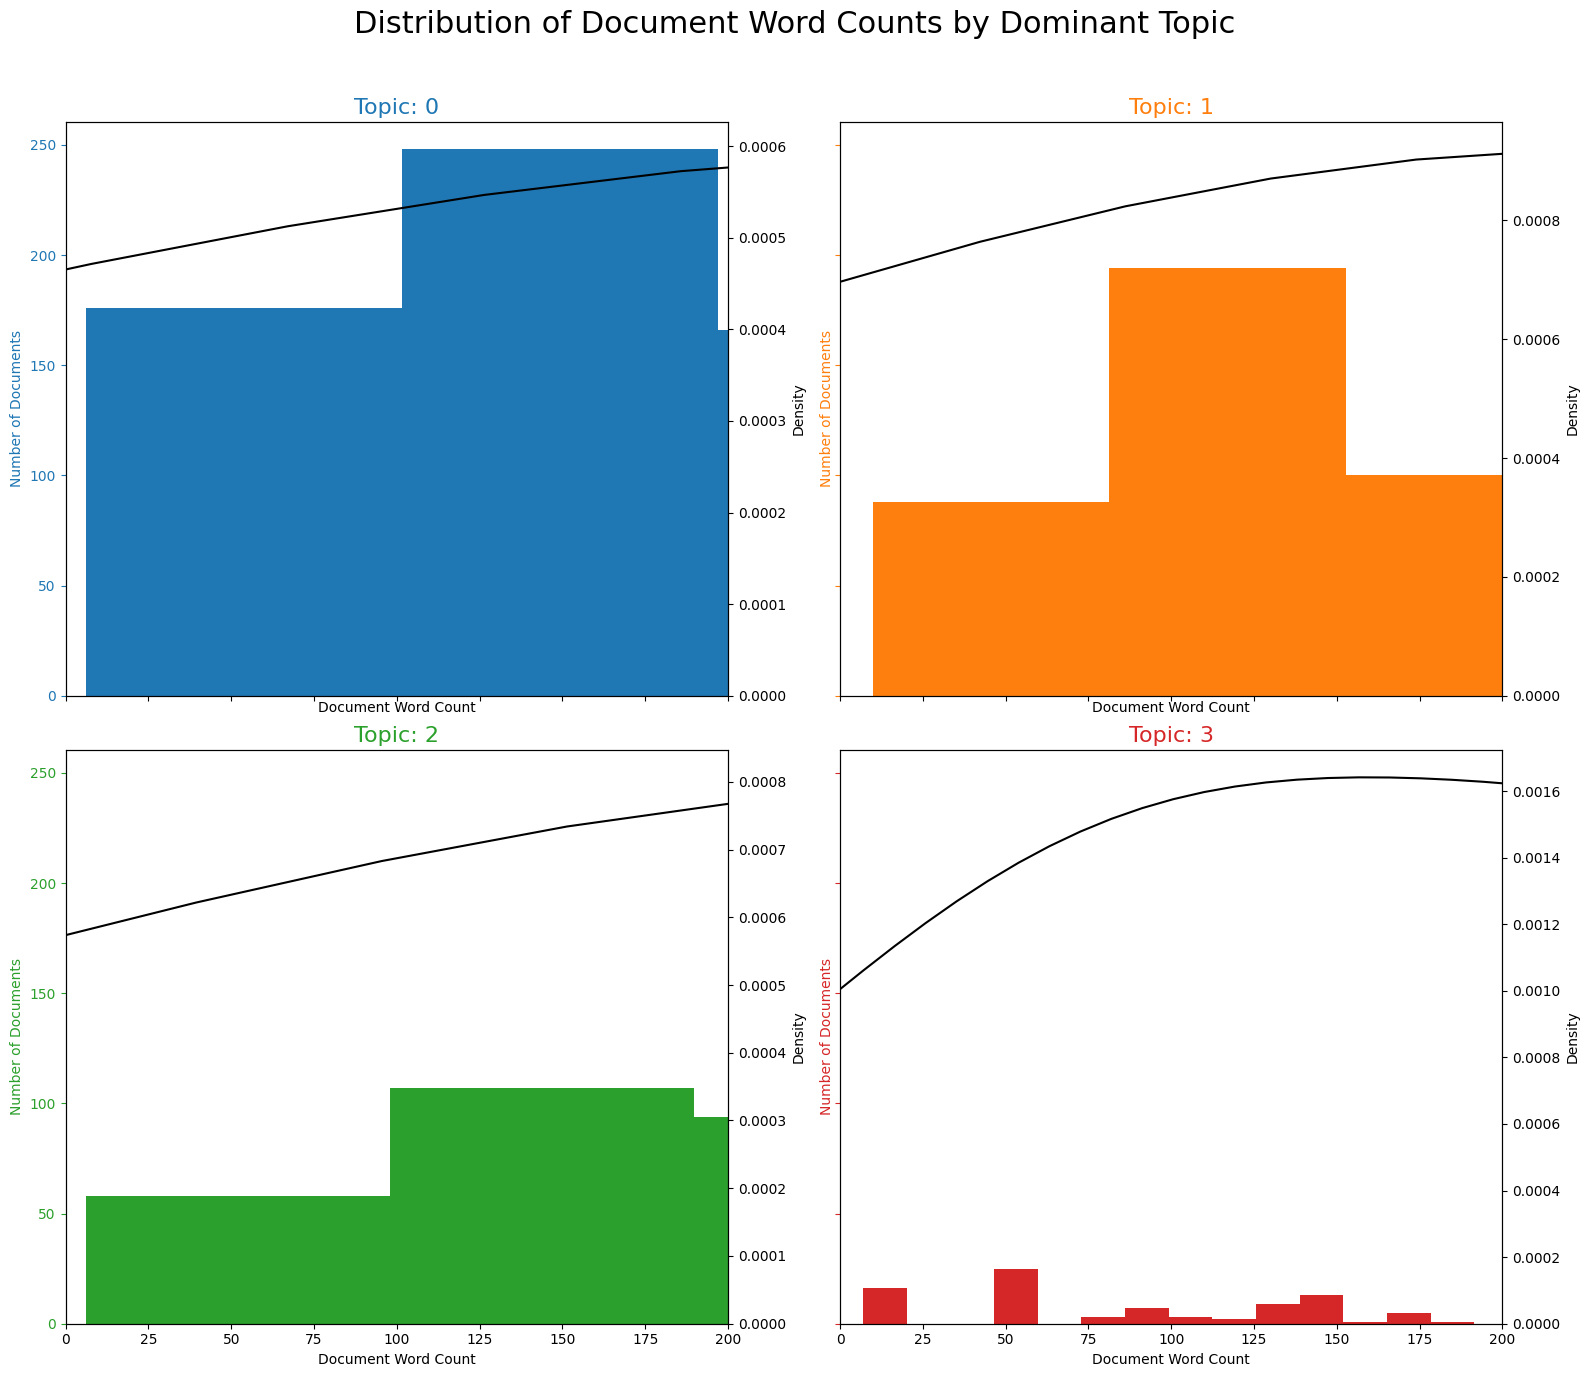

In [17]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=100, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 200), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,200,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

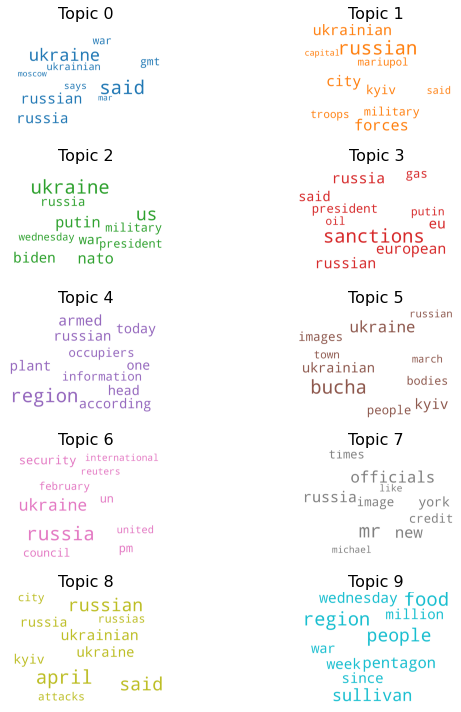

In [18]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [19]:

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()


/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/swagyangjh/opt/anaconda3/envs/641/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


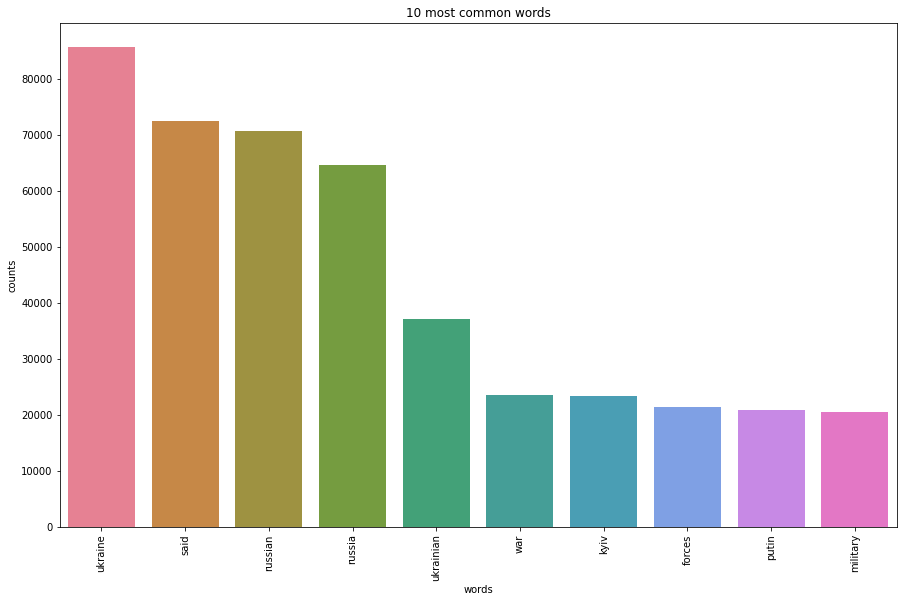

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(news[news["art_article_text"].notnull()]['art_article_text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [21]:

# delete bigrams which not contain the topic words

def word_drop_keywords(x):
    arr = [i.strip() for i in  x[0].split(",") if i.strip() not in ["russia","ukriane"] ]
    if len(arr) >=5:
        key_words = arr[:5]
    else:
        key_words = arr
    words = x[1]
    keep_words = []
    for i in range(len(words)):
        
        if i == 0:
            if len(set(words[i:i+1])&set(key_words)) > 0 :
                
                keep_words.append(words[i])
        elif i < len(words)-1 and i > 0:
            if len(set(words[i:i+2])&set(key_words)) > 0 or len(set(words[i-1:i+1])&set(key_words)) > 0 :

                keep_words.append(words[i])
        else:
            if words[i-1] in key_words:
                keep_words.append(words[i])
    return keep_words

In [22]:
new_text = df_dominant_topic[["Keywords","Text"]].apply(lambda x:word_drop_keywords(x),axis=1)
new_text = [i for i in new_text if len(i) >0]

In [23]:
new_data = [" ".join(i) for i in new_text ]

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(new_data, min_count=2, threshold=1) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[new_data], threshold=1)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [28]:
# 文本处理：将每个词词根词尾化，只保留名词、形容词、动词和副词。只保留这些词性标签，因为它们对句子的意义贡献最大。在这里，我使用空格来表示词目化。
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        # print(sent)
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(new_data) 

In [29]:
# Create Dictionary
id2word = Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [30]:
for topic in lda_model.print_topics(num_topics=10, num_words=8):
    print (topic[1])

0.393*"russian" + 0.083*"force" + 0.036*"troop" + 0.017*"military" + 0.015*"soldier" + 0.008*"accord" + 0.007*"kill" + 0.006*"destroy"
0.108*"region" + 0.074*"people" + 0.047*"image" + 0.046*"official" + 0.027*"announce" + 0.024*"food" + 0.023*"senior" + 0.021*"accord"
0.079*"apr" + 0.067*"gmt" + 0.020*"sanction" + 0.013*"official" + 0.011*"weapon" + 0.011*"oil" + 0.010*"fight" + 0.008*"claim"
0.232*"ukraine" + 0.095*"war" + 0.032*"crime" + 0.028*"invasion" + 0.017*"statement" + 0.017*"official" + 0.013*"invade" + 0.012*"support"
0.175*"ukrainian" + 0.105*"city" + 0.096*"kyiv" + 0.046*"force" + 0.037*"russian" + 0.028*"attack" + 0.020*"capital" + 0.017*"troop"


In [31]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.482425,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[diplomat, buy, russian, oil, urge, country, half, russian, gas, export, european, country, urge..."
1,1,0.0,0.705251,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[staff, armed, force, perm, region, republic, armed, force, punish, russian, federation, attack,..."
2,2,1.0,0.987453,"region, people, image, official, announce, food, senior, accord, luhansk, leave","[civilian, region, flee, luhansk, region, ruin, thousand, people, leave, region, region, tell, d..."
3,3,0.0,0.720613,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[defense, russian, aggression, russian, missile, russian, occupier, already, russian, occupier, ..."
4,4,3.0,0.657432,"ukraine, war, crime, invasion, statement, official, invade, support, zelenskyy, attack","[allegation, russian, troop, bucha, ukraine, image, ukraine, require, greenfield, vote, evidence..."
5,5,1.0,0.987453,"region, people, image, official, announce, food, senior, accord, luhansk, leave","[civilian, region, flee, luhansk, region, ruin, thousand, people, leave, region, region, tell, d..."
6,6,0.0,0.622238,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[destroy, russian, tank, echo, russian, military, defense, distribute, withdrawal, russian, forc..."
7,7,0.0,0.729946,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[russian, military, leader, russian, back, force, kyiv, northern, ukrainian, chernihiv]"
8,8,4.0,0.853436,"ukrainian, city, kyiv, force, russian, attack, capital, troop, port, mariupol","[warn, intensify, attack, ukrainian, capital, accuse, ukraine, target, russian, border, flagship..."
9,9,4.0,0.853437,"ukrainian, city, kyiv, force, russian, attack, capital, troop, port, mariupol","[warn, intensify, attack, ukrainian, capital, accuse, ukraine, target, russian, border, flagship..."


In [32]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.955967,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[russian, invader, blow, russian, army, force, losse, russian, troop, blow, russian, army, accor..."
1,1.0,0.987453,"region, people, image, official, announce, food, senior, accord, luhansk, leave","[civilian, region, flee, luhansk, region, ruin, thousand, people, leave, region, region, tell, d..."
2,2.0,0.800533,"apr, gmt, sanction, official, weapon, oil, fight, claim, ally, biden","[dollar, look, sanction, evasion, effectiveness, sanction, always, nation, leader, official, key..."
3,3.0,0.965810,"ukraine, war, crime, invasion, statement, official, invade, support, zelenskyy, attack","[commit, war, crime, ukraine, stop, appalled, civilian, crime, prosecute, war, result, war, crim..."
4,4.0,0.948870,"ukrainian, city, kyiv, force, russian, attack, capital, troop, port, mariupol","[russian, troop, ukrainian, official, russian, troop, southern, city, mykolaiv, ukrainian, offic..."


In [33]:
for topic in lda_model.print_topics(num_topics=10, num_words=10):
    print (topic[1])

0.393*"russian" + 0.083*"force" + 0.036*"troop" + 0.017*"military" + 0.015*"soldier" + 0.008*"accord" + 0.007*"kill" + 0.006*"destroy" + 0.006*"shell" + 0.006*"pro"
0.108*"region" + 0.074*"people" + 0.047*"image" + 0.046*"official" + 0.027*"announce" + 0.024*"food" + 0.023*"senior" + 0.021*"accord" + 0.020*"luhansk" + 0.019*"leave"
0.079*"apr" + 0.067*"gmt" + 0.020*"sanction" + 0.013*"official" + 0.011*"weapon" + 0.011*"oil" + 0.010*"fight" + 0.008*"claim" + 0.007*"ally" + 0.007*"biden"
0.232*"ukraine" + 0.095*"war" + 0.032*"crime" + 0.028*"invasion" + 0.017*"statement" + 0.017*"official" + 0.013*"invade" + 0.012*"support" + 0.011*"zelenskyy" + 0.011*"attack"
0.175*"ukrainian" + 0.105*"city" + 0.096*"kyiv" + 0.046*"force" + 0.037*"russian" + 0.028*"attack" + 0.020*"capital" + 0.017*"troop" + 0.016*"port" + 0.011*"mariupol"


# Visualization

In [34]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.955967,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[russian, invader, blow, russian, army, force, losse, russian, troop, blow, russian, army, accor..."
1,1.0,0.987453,"region, people, image, official, announce, food, senior, accord, luhansk, leave","[civilian, region, flee, luhansk, region, ruin, thousand, people, leave, region, region, tell, d..."
2,2.0,0.800533,"apr, gmt, sanction, official, weapon, oil, fight, claim, ally, biden","[dollar, look, sanction, evasion, effectiveness, sanction, always, nation, leader, official, key..."
3,3.0,0.965810,"ukraine, war, crime, invasion, statement, official, invade, support, zelenskyy, attack","[commit, war, crime, ukraine, stop, appalled, civilian, crime, prosecute, war, result, war, crim..."
4,4.0,0.948870,"ukrainian, city, kyiv, force, russian, attack, capital, troop, port, mariupol","[russian, troop, ukrainian, official, russian, troop, southern, city, mykolaiv, ukrainian, offic..."


In [35]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.482425,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[diplomat, buy, russian, oil, urge, country, half, russian, gas, export, european, country, urge..."
1,1,0.0,0.705251,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[staff, armed, force, perm, region, republic, armed, force, punish, russian, federation, attack,..."
2,2,1.0,0.987453,"region, people, image, official, announce, food, senior, accord, luhansk, leave","[civilian, region, flee, luhansk, region, ruin, thousand, people, leave, region, region, tell, d..."
3,3,0.0,0.720613,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[defense, russian, aggression, russian, missile, russian, occupier, already, russian, occupier, ..."
4,4,3.0,0.657432,"ukraine, war, crime, invasion, statement, official, invade, support, zelenskyy, attack","[allegation, russian, troop, bucha, ukraine, image, ukraine, require, greenfield, vote, evidence..."


In [36]:
# analysis article
news_tmp_1 = df_dominant_topic.iloc[0]
news_tmp_2 = df_dominant_topic.iloc[1]

In [37]:
keys_word_1 = [i.strip() for i in news_tmp_1["Keywords"].split(",")]
keys_word_2 = [i.strip() for i in news_tmp_2["Keywords"].split(",")]

In [38]:
common_keywords = list(set(keys_word_1) & set(keys_word_2))

In [39]:
news_text_1 = news_tmp_1["Text"]
news_text_2 = news_tmp_2["Text"]

In [41]:
# Count the words appear in the bigrams which is not the topic word 
def not_keywords_frequncy(text):
    word_dic = {}
    for grams in bigrams(text):
        if len(set(common_keywords) & set(grams)) >0:
            tmp = list(set(grams).difference(set(common_keywords)))
            for k in tmp:
                word_dic[k] = word_dic.get(k,0) + 1
    return word_dic

In [42]:
# Viz
def draw_from_dict(dicdata,RANGE=10, heng=1):
    plt.figure(figsize=(10,8))
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    print(by_value)
    x = []
    y = []
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    if heng == 0:
        plt.bar(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    elif heng == 1:
        plt.barh(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    else:
        return None

[('buy', 3), ('oil', 3), ('half', 2), ('gas', 2), ('street', 2), ('bucha', 1), ('army', 1), ('already', 1), ('energy', 1), ('sanction', 1), ('nation', 1), ('leader', 1), ('landsbergi', 1)]


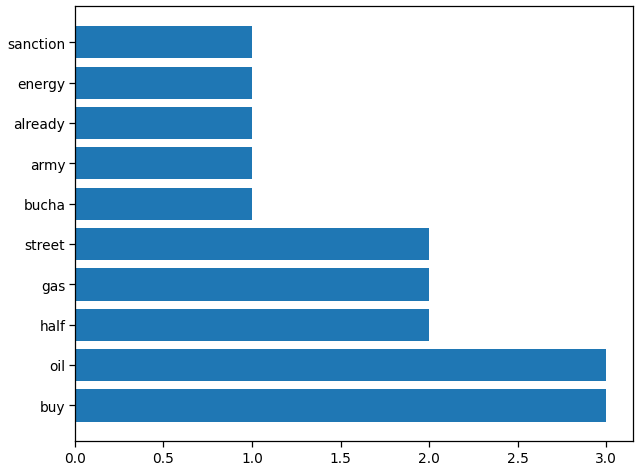

In [43]:
word_dic_1 = not_keywords_frequncy(news_text_1)
draw_from_dict(word_dic_1)

[('armed', 16), ('invader', 7), ('occupier', 6), ('commit', 5), ('kyiv', 3), ('capture', 3), ('equipment', 3), ('ukraine', 3), ('region', 3), ('number', 3), ('punish', 2), ('army', 2), ('declare', 2), ('today', 2), ('special', 2), ('atrocity', 2), ('sanction', 2), ('kishida', 2), ('general', 2), ('search', 2), ('ukrainian', 2), ('remain', 2), ('location', 2), ('time', 2), ('newspaper', 2), ('drag', 2), ('facebook', 2), ('perm', 1), ('federation', 1), ('attack', 1), ('associate', 1), ('hospital', 1), ('scale', 1), ('offensive', 1), ('wagon', 1), ('riot', 1), ('marauder', 1), ('paratrooper', 1), ('retreat', 1), ('aggressor', 1), ('vehicle', 1), ('brigade', 1), ('document', 1), ('diplomat', 1), ('situation', 1), ('detail', 1), ('liberate', 1), ('occupy', 1), ('country', 1), ('propagandist', 1), ('yacht', 1), ('businessman', 1), ('armored', 1), ('support', 1), ('informer', 1), ('activity', 1), ('crime', 1), ('relation', 1), ('expel', 1), ('sense', 1), ('dictator', 1), ('gas', 1), ('fascist

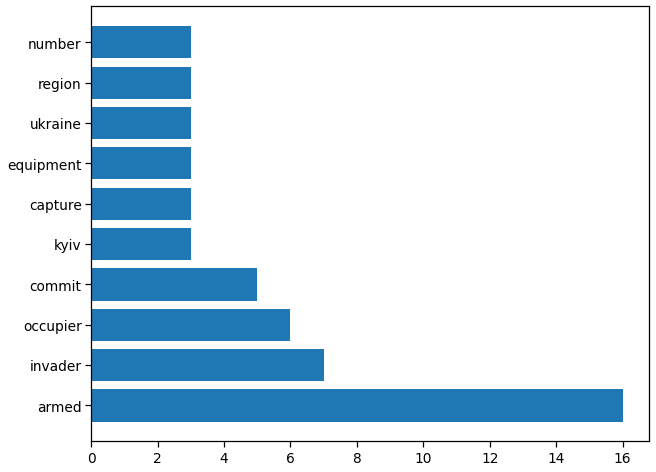

In [44]:
word_dic_2 = not_keywords_frequncy(news_text_2)
draw_from_dict(word_dic_2)

# Theme prediction

In [45]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.482425,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[diplomat, buy, russian, oil, urge, country, half, russian, gas, export, european, country, urge..."
1,1,0.0,0.705251,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[staff, armed, force, perm, region, republic, armed, force, punish, russian, federation, attack,..."
2,2,1.0,0.987453,"region, people, image, official, announce, food, senior, accord, luhansk, leave","[civilian, region, flee, luhansk, region, ruin, thousand, people, leave, region, region, tell, d..."
3,3,0.0,0.720613,"russian, force, troop, military, soldier, accord, kill, destroy, shell, pro","[defense, russian, aggression, russian, missile, russian, occupier, already, russian, occupier, ..."
4,4,3.0,0.657432,"ukraine, war, crime, invasion, statement, official, invade, support, zelenskyy, attack","[allegation, russian, troop, bucha, ukraine, image, ukraine, require, greenfield, vote, evidence..."


In [46]:
"""word2vec"""
def word2vec_feature(data,emb_size = 32 ):

    sentences = data['Text'].values.tolist()

    model = Word2Vec(sentences, vector_size=emb_size, window=6, min_count=5, sg=0, hs=0, seed=1, epochs=5)

    emb_matrix = []

    for seq in sentences:
        vec = []
        for w in seq:
            if w in model.wv:
                vec.append(model.wv[w])
        if len(vec) > 0:
            emb_matrix.append(np.mean(vec, axis=0))
        else:
            emb_matrix.append([0] * emb_size)
    
    vec_feature = pd.DataFrame(emb_matrix,columns=['tag_emb_{}'.format(i) for i in range(emb_size)])
    return vec_feature

In [47]:
# w2v embedding
embed_size = 32
vec_feature = word2vec_feature(df_dominant_topic,emb_size = embed_size)

In [48]:
theme_label = df_dominant_topic["Dominant_Topic"]

In [50]:
x_train,x_test,y_train,y_test = train_test_split(vec_feature,theme_label)

# CLF is the fitted model
# here is random forest
the y_score is a matrix, whose shape is (train, group number)
 for example, suppose we have 200 train data. and we need to cluster them into 5 groups the matrix is (200,5)
 moreover, the (i,j)th data means the probaboloty of the ith data is to be grouped into j

In [55]:
dtc = RandomForestClassifier(random_state=0)

clf = dtc.fit(X=x_train, y=y_train)

y_score = clf.predict_proba(x_test) 

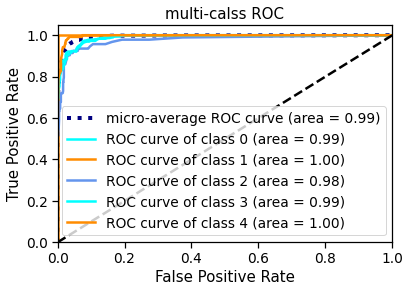

In [59]:
# Perform roc curve at 0-1, value prediction, prediction accuracy

y_label = pd.get_dummies(y_test).values
y_score = clf.predict_proba(x_test)
n_classes = 5


# ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 

fpr["micro"], tpr["micro"], _ = roc_curve(y_label.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
 
 
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, 
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC')
plt.legend(loc="lower right")
plt.show()

In [60]:
"""LR"""
from sklearn.linear_model import LogisticRegression

# trainning
clf = LogisticRegression(multi_class="multinomial", solver="newton-cg", max_iter=1000)
clf.fit(x_train,y_train)


LogisticRegression(max_iter=1000, multi_class='multinomial', solver='newton-cg')

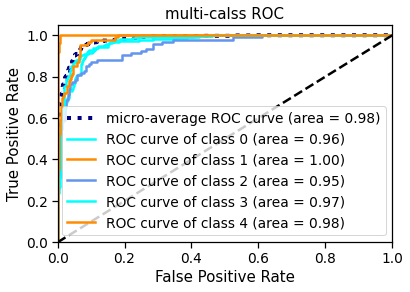

In [61]:

# viz the value range of auc is between 0-1, the higher the value, the more accuracy
y_label = pd.get_dummies(y_test).values
y_score = clf.predict_proba(x_test)
n_classes = 5


# each class roc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 

fpr["micro"], tpr["micro"], _ = roc_curve(y_label.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
 
 
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, 
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC')
plt.legend(loc="lower right")
plt.show()